In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import optuna


import gc
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
sample_pl = []

for i in range(9):
    df_pl = pl.read_parquet(f'data/train.parquet/partition_id={i}/part-0.parquet')
    sample_pl.append(df_pl)


df_pl = pl.concat(sample_pl)
df_pl.head()

shape: (5, 92)
┌─────────┬─────────┬───────────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ weight   ┆ … ┆ responder_ ┆ responder_ ┆ responder_ ┆ responder_ │
│ ---     ┆ ---     ┆ ---       ┆ ---      ┆   ┆ 5          ┆ 6          ┆ 7          ┆ 8          │
│ i16     ┆ i16     ┆ i8        ┆ f32      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│         ┆         ┆           ┆          ┆   ┆ f32        ┆ f32        ┆ f32        ┆ f32        │
╞═════════╪═════════╪═══════════╪══════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0       ┆ 0       ┆ 1         ┆ 3.889038 ┆ … ┆ 1.218368   ┆ 0.775981   ┆ 0.346999   ┆ 0.095504   │
│ 0       ┆ 0       ┆ 7         ┆ 1.370613 ┆ … ┆ 5.0        ┆ 0.703665   ┆ 0.216683   ┆ 0.778639   │
│ 0       ┆ 0       ┆ 9         ┆ 2.285698 ┆ … ┆ 0.099793   ┆ 2.109352   ┆ 0.670881   ┆ 0.772828   │
│ 0       ┆ 0       ┆ 10        ┆ 0.690606 ┆ … ┆ 1.225376   ┆ 1.114137   ┆ 0.775199   ┆ -1.379516  │
│ 0       ┆ 0       ┆ 14        ┆ 0.44057  ┆ … ┆ -5.0       ┆ -3.57282   ┆ -1.089123  ┆ -5.0       │
└─────────┴─────────┴───────────┴──────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [3]:
df_pl.glimpse()

Rows: 40852762
Columns: 92
$ date_id     <i16> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ time_id     <i16> 0, 0, 0, 0, 0, 0, 0, 0, 1, 1
$ symbol_id    <i8> 1, 7, 9, 10, 14, 16, 19, 33, 1, 7
$ weight      <f32> 3.889038324356079, 1.3706134557724, 2.285698413848877, 0.6906061172485352, 0.4405696392059326, 1.1182688474655151, 2.4563307762145996, 1.6634076833724976, 3.889038324356079, 1.3706134557724
$ feature_00  <f32> None, None, None, None, None, None, None, None, None, None
$ feature_01  <f32> None, None, None, None, None, None, None, None, None, None
$ feature_02  <f32> None, None, None, None, None, None, None, None, None, None
$ feature_03  <f32> None, None, None, None, None, None, None, None, None, None
$ feature_04  <f32> None, None, None, None, None, None, None, None, None, None
$ feature_05  <f32> 0.8510326743125916, 0.6769610643386841, 1.056284785270691, 1.1393661499023438, 0.9552001953125, 1.0924279689788818, 0.7472313642501831, 1.182569146156311, 0.9176132678985596, 0.8771722912788391
$ 

In [32]:
test_pl = pl.read_parquet(f'data/test.parquet/date_id=0/part-0.parquet')
test_pl.head()
test_pl.glimpse()

Rows: 39
Columns: 85
$ row_id      <i64> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ date_id     <i16> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ time_id     <i16> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ symbol_id    <i8> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ weight      <f32> 3.1699976921081543, 2.1659929752349854, 3.0655500888824463, 2.698641538619995, 1.8033300638198853, 2.605776309967041, 1.0479928255081177, 4.231288909912109, 2.6005237102508545, 1.2562748193740845
$ is_scored  <bool> True, True, True, True, True, True, True, True, True, True
$ feature_00  <f32> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ feature_01  <f32> 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0
$ feature_02  <f32> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ feature_03  <f32> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ feature_04  <f32> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
$ feature_05  <f32> -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0
$ feature_06  <f32> -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0

### Missing values

In [4]:
null_counts = df_pl.null_count().transpose(include_header=True)
null_counts = null_counts.to_pandas()
null_counts.rename(columns={'column':'Feature', 'column_0':'Count'}, inplace=True)
null_counts = null_counts[null_counts['Count']>0]
null_counts = null_counts.sort_values('Count',ascending=False)
null_counts['Percentage'] = round((null_counts['Count']/40852762)*100,2)
null_counts

Feature    Count  Percentage
30  feature_26  8358545       20.46
31  feature_27  8358545       20.46
35  feature_31  8358545       20.46
25  feature_21  8358545       20.46
43  feature_39  3859871        9.45
46  feature_42  3859871        9.45
54  feature_50  3813322        9.33
57  feature_53  3813322        9.33
7   feature_03  3182052        7.79
5   feature_01  3182052        7.79
6   feature_02  3182052        7.79
8   feature_04  3182052        7.79
4   feature_00  3182052        7.79
19  feature_15  1053731        2.58
45  feature_41   976335        2.39
48  feature_44   976335        2.39
56  feature_52   928222        2.27
59  feature_55   928222        2.27
78  feature_74   422052        1.03
77  feature_73   422052        1.03
37  feature_33   416912        1.02
36  feature_32   416912        1.02
62  feature_58   416907        1.02
70  feature_66   317024        0.78
49  feature_45   317024        0.78
50  feature_46   317024        0.78
69  feature_65   317024        0.78
66  feature_62   292701        0.72
12  feature_08   262495        0.64
68  feature_64   237562        0.58
67  feature_63   227470        0.56
21  feature_17   175910        0.43
44  feature_40    67854        0.17
47  feature_43    67854        0.17
80  feature_76    47950        0.12
79  feature_75    47950        0.12
82  feature_78    18098        0.04
81  feature_77    18098        0.04
55  feature_51    13805        0.03
58  feature_54    13805        0.03
41  feature_37      849        0.00
20  feature_16      261        0.00
23  feature_19      226        0.00
22  feature_18      226        0.00
60  feature_56      226        0.00
61  feature_57      226        0.00
51  feature_47       87        0.00

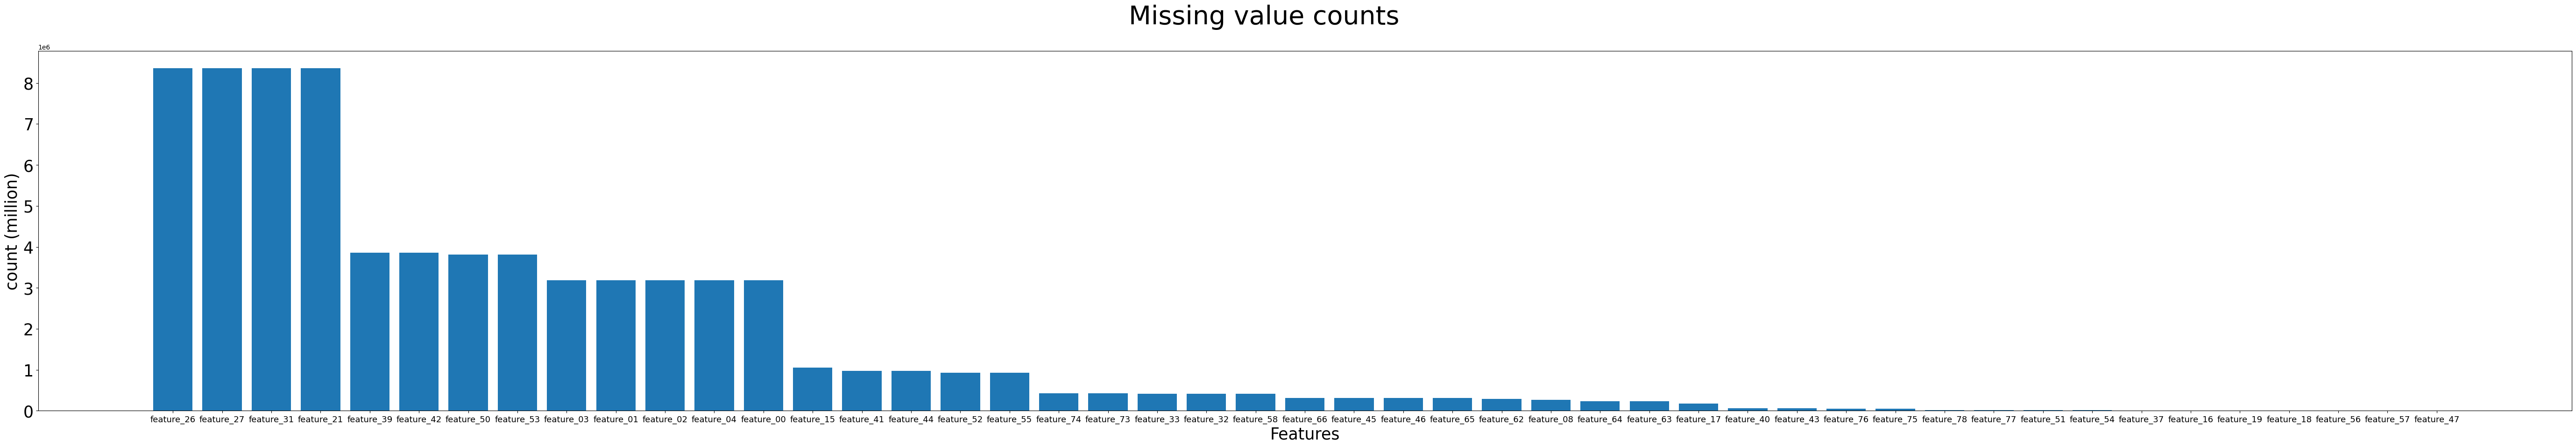

In [5]:
plt.figure(figsize=(70, 10))
plt.bar(null_counts['Feature'], null_counts['Count'])
plt.ylabel('count (million)', fontsize=25)
plt.xlabel('Features', fontsize=25)
plt.suptitle('Missing value counts', fontsize=40)
plt.yticks(fontsize=25)
plt.xticks(fontsize=13)
plt.savefig('missing_values.png')
plt.show()

### Distribution of Features

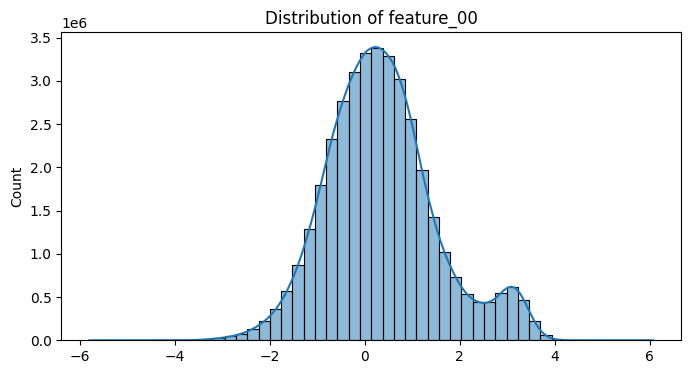

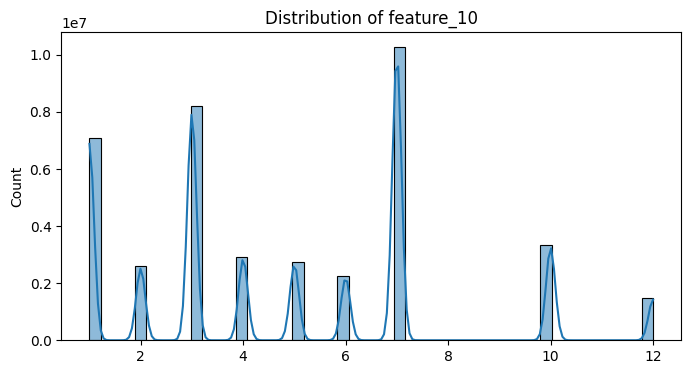

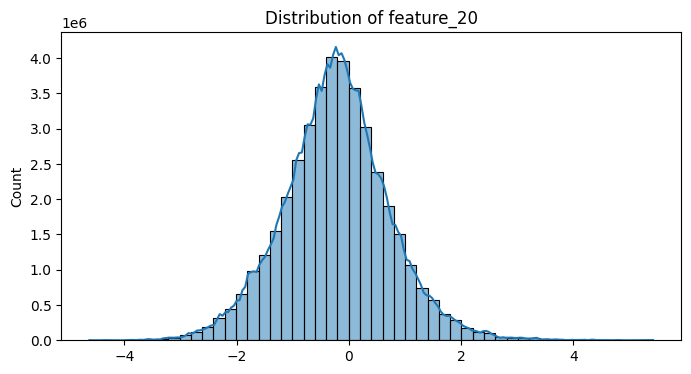

In [6]:
# Plot distribution of a few features
features_to_plot = ['feature_00', 'feature_10', 'feature_20']
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_pl[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.savefig(f"{feature}_distribution.png")
    plt.show()

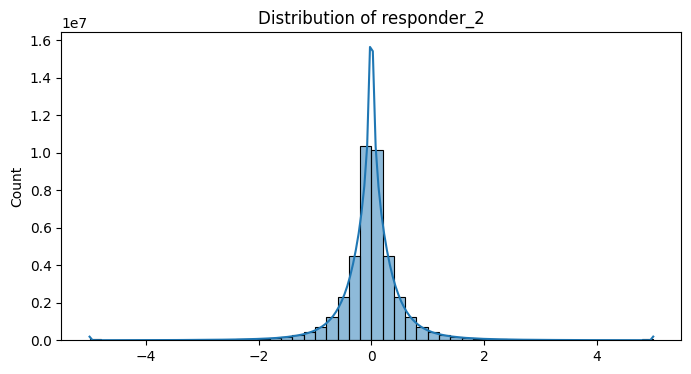

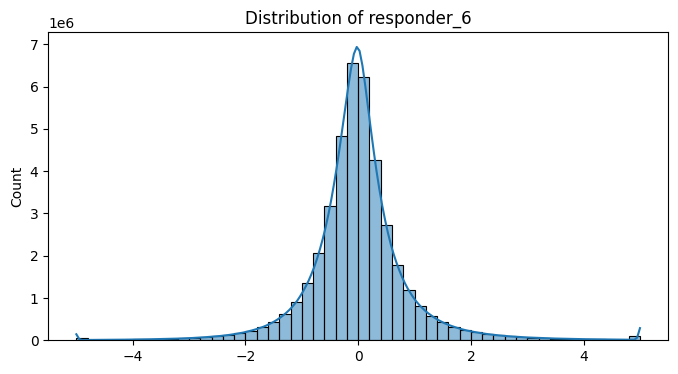

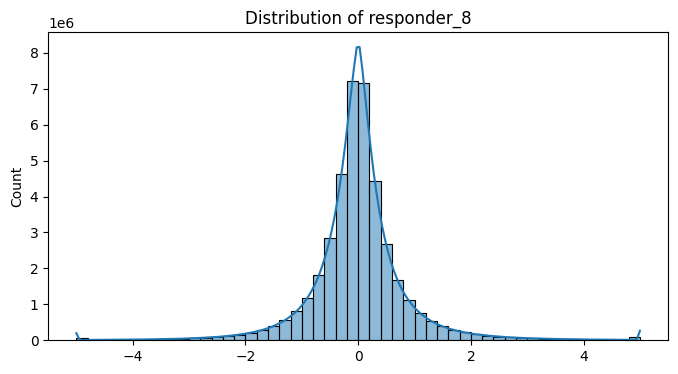

In [7]:
features_to_plot = ['responder_2', 'responder_6', 'responder_8']
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_pl[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.savefig(f"{feature}_distribution.png")
    plt.show()


### Data Analysis in Time Series

In [8]:
date_responder6 = df_pl.select(['date_id','time_id', 'responder_6']).to_pandas()
date_responder6

date_id  time_id  responder_6
0               0        0     0.775981
1               0        0     0.703665
2               0        0     2.109352
3               0        0     1.114137
4               0        0    -3.572820
...           ...      ...          ...
40852757     1529      967    -0.063972
40852758     1529      967    -0.230132
40852759     1529      967    -0.207259
40852760     1529      967    -0.082444
40852761     1529      967    -0.125738

[40852762 rows x 3 columns]

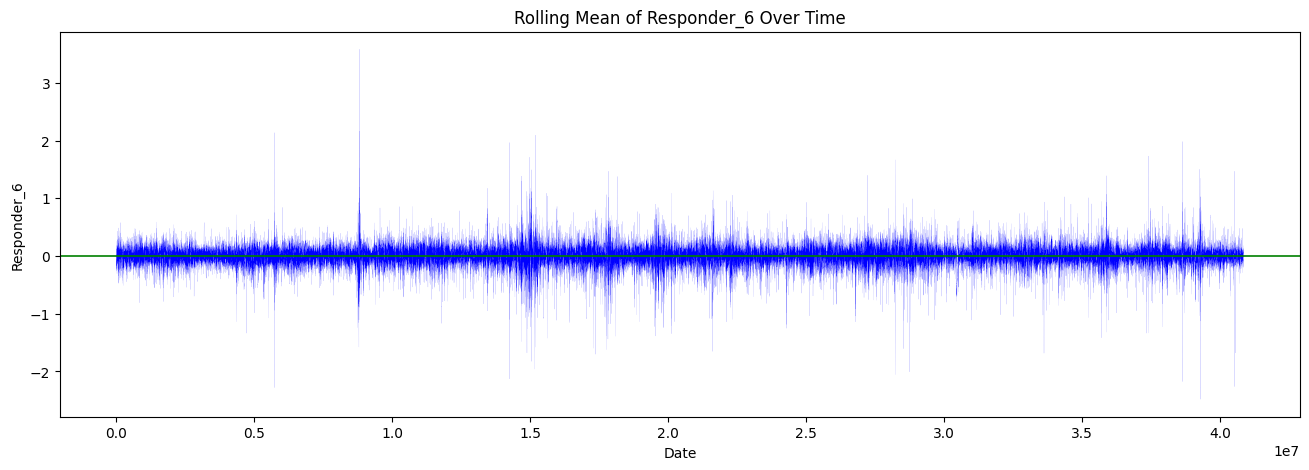

In [9]:
plt.figure(figsize=(16, 5))
date_responder6['responder_6'].rolling(window=1000).mean().plot(color='blue',linewidth =0.05)
plt.title("Rolling Mean of Responder_6 Over Time")
plt.xlabel("Date")
plt.ylabel("Responder_6")
# plt.grid(color = 'lightgrey' , linewidth=0.8)
plt.axhline(0, color='green', linestyle='-', linewidth=1.2)
plt.savefig('responder_6_rolling_mean.png')
plt.show()

### Feature Correlation

In [10]:
df_pl.corr()

shape: (92, 92)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ date_id   ┆ time_id   ┆ symbol_id ┆ weight    ┆ … ┆ responder ┆ responder ┆ responder ┆ responde │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ _5        ┆ _6        ┆ _7        ┆ r_8      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 1.0       ┆ 0.081894  ┆ 0.133638  ┆ 0.184186  ┆ … ┆ -0.021539 ┆ 0.001608  ┆ 0.007431  ┆ 0.000227 │
│ 0.081894  ┆ 1.0       ┆ 0.013897  ┆ 0.012436  ┆ … ┆ -0.000482 ┆ -0.011613 ┆ -0.017841 ┆ -0.00529 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 6        │
│ 0.133638  ┆ 0.013897  ┆ 1.0       ┆ -0.221548 ┆ … ┆ -0.001377 ┆ 0.001084  ┆ 0.003304  ┆ 0.000439 │
│ 0.184186  ┆ 0.012436  ┆ -0.221548 ┆ 1.0       ┆ … ┆ -0.013637 ┆ -0.000918 ┆ -0.00625  ┆ -0.00001 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ NaN       ┆ NaN       ┆ NaN       ┆ NaN       ┆ … ┆ NaN       ┆ NaN       ┆ NaN       ┆ NaN      │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ -0.009317 ┆ 0.011616  ┆ 0.002532  ┆ -0.013267 ┆ … ┆ 0.249495  ┆ 0.365234  ┆ 0.822279  ┆ 0.168449 │
│ -0.021539 ┆ -0.000482 ┆ -0.001377 ┆ -0.013637 ┆ … ┆ 1.0       ┆ 0.324874  ┆ 0.157836  ┆ 0.675198 │
│ 0.001608  ┆ -0.011613 ┆ 0.001084  ┆ -0.000918 ┆ … ┆ 0.324874  ┆ 1.0       ┆ 0.430494  ┆ 0.442649 │
│ 0.007431  ┆ -0.017841 ┆ 0.003304  ┆ -0.00625  ┆ … ┆ 0.157836  ┆ 0.430494  ┆ 1.0       ┆ 0.203218 │
│ 0.000227  ┆ -0.005296 ┆ 0.000439  ┆ -0.000012 ┆ … ┆ 0.675198  ┆ 0.442649  ┆ 0.203218  ┆ 1.0      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [5]:
# Select some data to plot
df_pl_small = df_pl[:9000000].to_pandas()
df_pl_small_corr = df_pl_small.corr()
df_pl_small_corr.drop(['date_id', 'time_id', 'symbol_id'], axis=1, inplace=True)
df_pl_small_corr.drop(['date_id', 'time_id', 'symbol_id'], axis=0, inplace=True)

In [6]:
df_pl_small_corr

weight  feature_00  feature_01  feature_02  feature_03  \
weight       1.000000   -0.057800    0.000120   -0.057577   -0.057810   
feature_00  -0.057800    1.000000    0.039672    0.915244    0.917367   
feature_01   0.000120    0.039672    1.000000   -0.031391   -0.020279   
feature_02  -0.057577    0.915244   -0.031391    1.000000    0.918855   
feature_03  -0.057810    0.917367   -0.020279    0.918855    1.000000   
...               ...         ...         ...         ...         ...   
responder_4 -0.012361   -0.000515   -0.007877    0.000438    0.000174   
responder_5 -0.001717    0.002387   -0.006215    0.003810    0.002706   
responder_6  0.001156    0.002831   -0.006840    0.004689    0.003351   
responder_7 -0.007849    0.005394    0.003145    0.005893    0.005525   
responder_8  0.001185    0.001991   -0.006062    0.003722    0.002288   

             feature_04  feature_05  feature_06  feature_07  feature_08  ...  \
weight         0.000387    0.000911   -0.000041    0.000172   -0.000695  ...   
feature_00     0.023350   -0.033039   -0.000258   -0.009063    0.040452  ...   
feature_01     0.293187    0.022993    0.013951    0.049510    0.142328  ...   
feature_02    -0.032746   -0.029437   -0.005339   -0.015654    0.027553  ...   
feature_03     0.002708   -0.033790   -0.001470   -0.012508    0.031757  ...   
...                 ...         ...         ...         ...         ...  ...   
responder_4   -0.012788   -0.010011   -0.022278   -0.016763    0.000737  ...   
responder_5   -0.019491   -0.023095   -0.068376   -0.044130    0.008937  ...   
responder_6   -0.027958   -0.022487   -0.058666   -0.038492    0.013777  ...   
responder_7   -0.010398   -0.018778   -0.029323   -0.023680    0.020040  ...   
responder_8   -0.028444   -0.028228   -0.103851   -0.060178    0.010717  ...   

             feature_78  responder_0  responder_1  responder_2  responder_3  \
weight        -0.124340    -0.001413     0.000241    -0.000467    -0.003072   
feature_00     0.019980    -0.002105    -0.004096    -0.000762     0.001328   
feature_01     0.036008    -0.009302    -0.023470    -0.001635    -0.010685   
feature_02     0.016105    -0.001763    -0.002397    -0.000899     0.003048   
feature_03     0.016502    -0.001633    -0.002634    -0.000659     0.001965   
...                 ...          ...          ...          ...          ...   
responder_4   -0.005751     0.130422     0.333509     0.067541     0.432011   
responder_5   -0.001408     0.249261     0.129039     0.478968     0.505272   
responder_6   -0.007393    -0.090261    -0.047620    -0.053306     0.643678   
responder_7   -0.004346    -0.038686    -0.096253    -0.024120     0.326047   
responder_8   -0.001519    -0.036108    -0.023468    -0.120051     0.298108   

             responder_4  responder_5  responder_6  responder_7  responder_8  
weight         -0.012361    -0.001717     0.001156    -0.007849     0.001185  
feature_00     -0.000515     0.002387     0.002831     0.005394     0.001991  
feature_01     -0.007877    -0.006215    -0.006840     0.003145    -0.006062  
feature_02      0.000438     0.003810     0.004689     0.005893     0.003722  
feature_03      0.000174     0.002706     0.003351     0.005525     0.002288  
...                  ...          ...          ...          ...          ...  
responder_4     1.000000     0.242915     0.309937     0.670945     0.144973  
responder_5     0.242915     1.000000     0.281389     0.150998     0.552163  
responder_6     0.309937     0.281389     1.000000     0.436222     0.443882  
responder_7     0.670945     0.150998     0.436222     1.000000     0.205656  
responder_8     0.144973     0.552163     0.443882     0.205656     1.000000  

[89 rows x 89 columns]

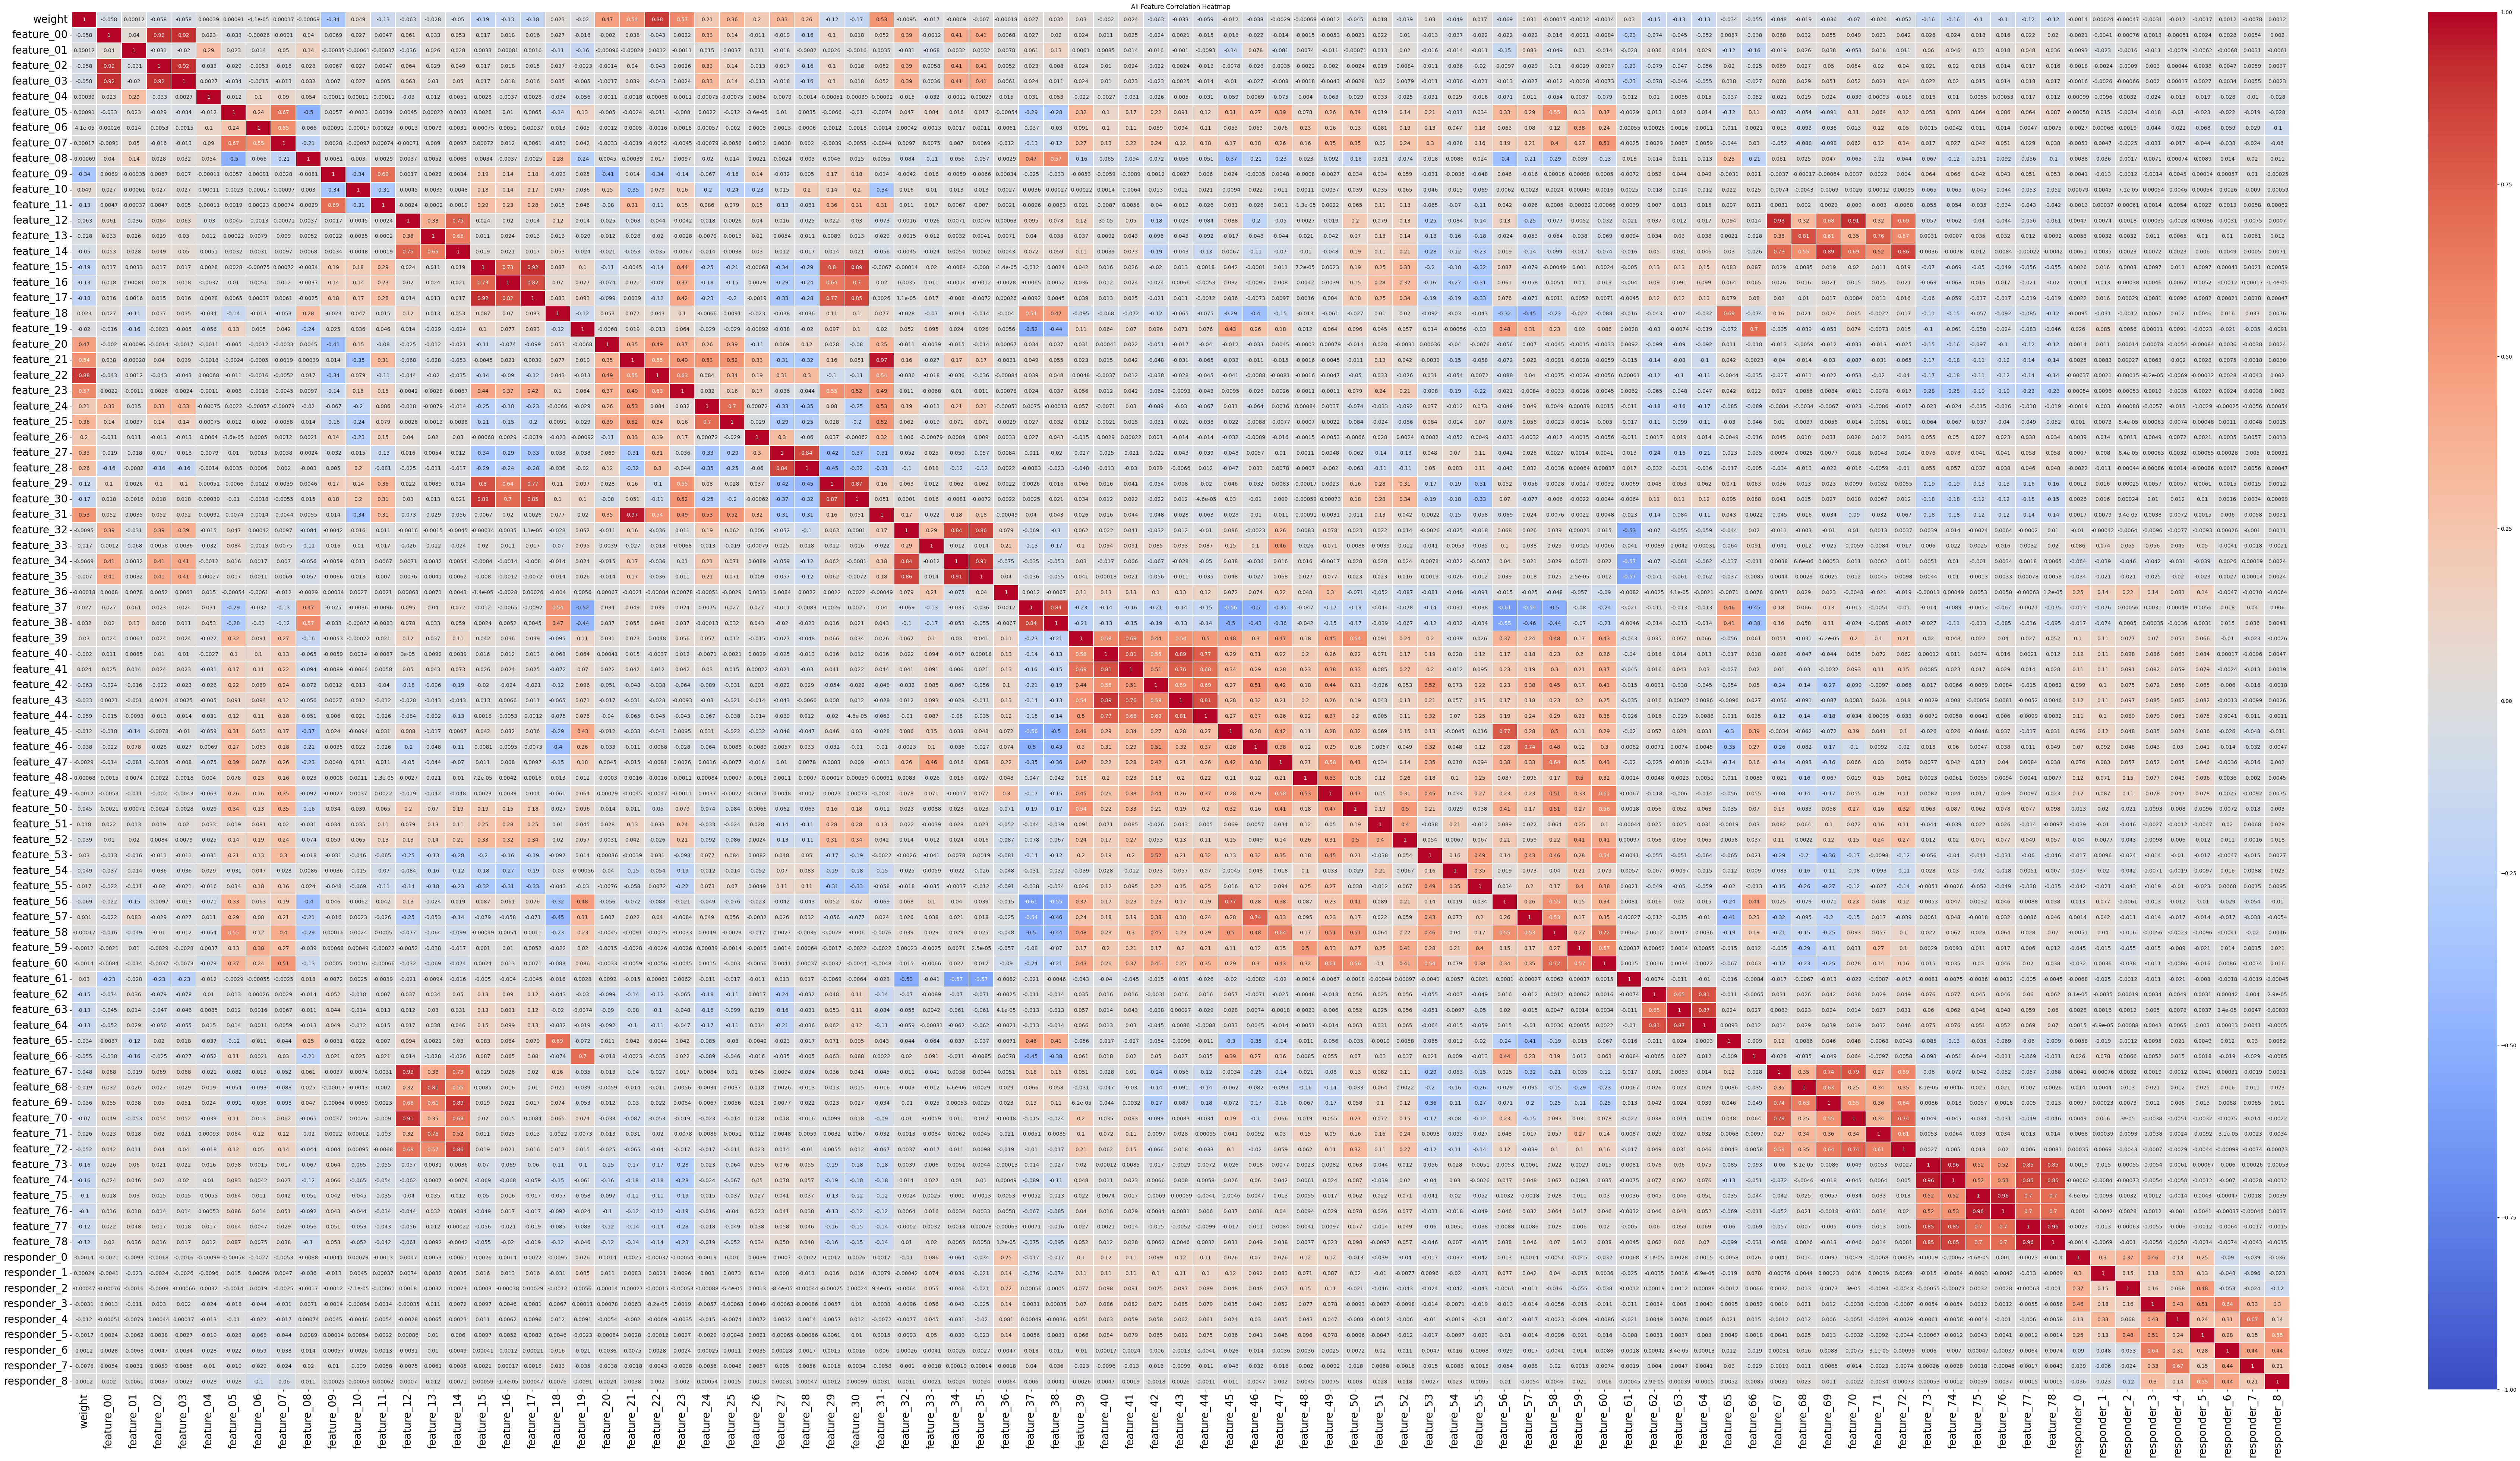

In [7]:
# Plot heatmap to visualize feature correlations
plt.figure(figsize=(96, 48))
sns.heatmap(df_pl_small_corr, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot=True, linewidth=0.05)
plt.title("All Feature Correlation Heatmap")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('all_feature_correlation_heatmap.png')
plt.show()

Corealation between Features¶
Feature_73 - Feature_74 (.96)
Feature_77 - Feature_78 (.96)
Feature_67 - Feature_12 (.93)
Feature_70 - Feature_12 (.91)
Feature_68 - Feature_13 (.81)
Feature_72 - Feature_14 (.86)
Feature_69 - Feature_14 (.89)
Feature_15 - Feature_30 (.89)
Feature_15 - Feature_17 (.92)
Feature_15 - Feature_29 (.8)
Feature_31 - Feature_21 (.97)
Feature_00 - Feature_02 (.92)
Feature_22 - weight (.88)
Feature_40 - Feature_43 (.89)
Feature_40 - Feature_41 (.81)
Feature_35 - Feature_34 (.91)
Feature_35 - Feature_32 (.86)
Feature_34 - Feature_32 (.84)

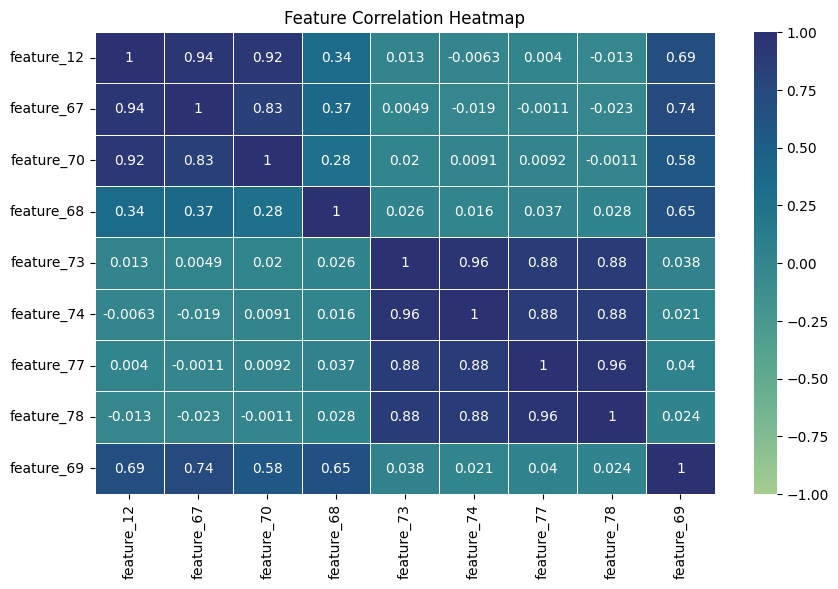

In [8]:
corr_matrix = df_pl.select(['feature_12','feature_67','feature_70','feature_68', \
                           'feature_73','feature_74','feature_77','feature_78','feature_69',]).to_pandas().corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap="crest", center=0, vmin=-1, vmax=1,annot=True, linewidth=0.5)
plt.title("Feature Correlation Heatmap")
plt.savefig('feature_correlation_heatmap.png')
plt.show()

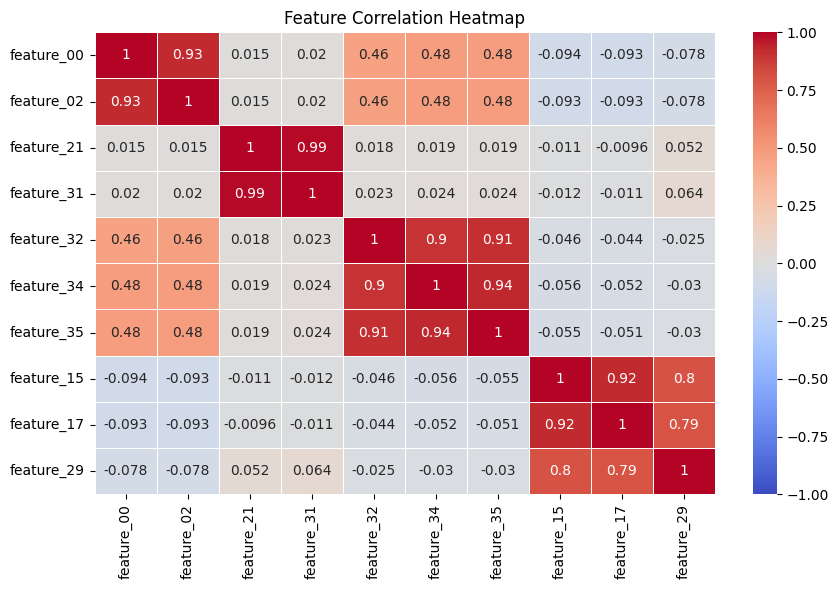

In [9]:
corr_matrix = df_pl.select(['feature_00','feature_02','feature_21','feature_31', \
                           'feature_32','feature_34','feature_35','feature_15','feature_17','feature_29']).to_pandas().corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap="coolwarm",  center=0, vmin=-1, vmax=1,annot=True, linewidth=0.5)
plt.title("Feature Correlation Heatmap")
plt.savefig('feature_correlation_heatmap_2.png')
plt.show()

In [3]:
# high related and missing values
Features_to_remove = ['feature_74','feature_78','feature_12','feature_70','feature_13','feature_14','feature_69', \
                      'feature_30', 'feature_17','feature_29','feature_21','feature_02','feature_43','feature_41', \
                        'feature_34','feature_32', \
                        'feature_26', 'feature_27', 'feature_31', 'feature_21', 'feature_39', \
                        'feature_42', 'feature_50', 'feature_53', 'feature_03', 'feature_01', 'feature_02', \
                        'feature_04', 'feature_00'] # missing values|

In [4]:
# Remove the specified features from the dataset
df_pl_clean = df_pl.drop(Features_to_remove)

# Verify the features have been removed
print(f"Number of features after removal: {len(df_pl_clean.columns)}")
print("Remaining features:", df_pl_clean.columns)
df_pl_clean.head()
df_pl_clean.shape


Number of features after removal: 65
Remaining features: ['date_id', 'time_id', 'symbol_id', 'weight', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_15', 'feature_16', 'feature_18', 'feature_19', 'feature_20', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_28', 'feature_33', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_40', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_51', 'feature_52', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_71', 'feature_72', 'feature_73', 'feature_75', 'feature_76', 'feature_77', 'responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_6', 'responder_7', 'responder_8']


(40852762, 65)

In [19]:
null_counts = df_pl_clean.null_count().transpose(include_header=True)
null_counts = null_counts.to_pandas()
null_counts.rename(columns={'column':'Feature', 'column_0':'Count'}, inplace=True)
null_counts = null_counts[null_counts['Count']>0]
null_counts = null_counts.sort_values('Count',ascending=False)
null_counts['Percentage'] = round((null_counts['Count']/40852762)*100,2)
null_counts

Feature    Count  Percentage
11  feature_15  1053731        2.58
27  feature_44   976335        2.39
36  feature_55   928222        2.27
34  feature_52   928222        2.27
52  feature_73   422052        1.03
21  feature_33   416912        1.02
39  feature_58   416907        1.02
47  feature_66   317024        0.78
29  feature_46   317024        0.78
28  feature_45   317024        0.78
46  feature_65   317024        0.78
43  feature_62   292701        0.72
7   feature_08   262495        0.64
45  feature_64   237562        0.58
44  feature_63   227470        0.56
26  feature_40    67854        0.17
54  feature_76    47950        0.12
53  feature_75    47950        0.12
55  feature_77    18098        0.04
33  feature_51    13805        0.03
35  feature_54    13805        0.03
24  feature_37      849        0.00
12  feature_16      261        0.00
13  feature_18      226        0.00
37  feature_56      226        0.00
14  feature_19      226        0.00
38  feature_57      226        0.00
30  feature_47       87        0.00

In [5]:
# fill the missing values in features with 0
fill_cols = df_pl_clean.columns[4:56]
df_pl_clean = df_pl_clean.with_columns(
    pl.col(fill_cols).fill_null(0),
)

In [6]:
null_counts = df_pl_clean.null_count().transpose(include_header=True)
null_counts = null_counts.to_pandas()
null_counts.rename(columns={'column':'Feature', 'column_0':'Count'}, inplace=True)
null_counts = null_counts[null_counts['Count']>0]
null_counts = null_counts.sort_values('Count',ascending=False)
null_counts['Percentage'] = round((null_counts['Count']/40852762)*100,2)
null_counts

Empty DataFrame
Columns: [Feature, Count, Percentage]
Index: []

In [7]:
del df_pl
# save memory

In [33]:
df_pl_clean.filter(pl.col('date_id')>1520)

shape: (336_864, 65)
┌─────────┬─────────┬───────────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ date_id ┆ time_id ┆ symbol_id ┆ weight   ┆ … ┆ responder_ ┆ responder_ ┆ responder_ ┆ responder_ │
│ ---     ┆ ---     ┆ ---       ┆ ---      ┆   ┆ 5          ┆ 6          ┆ 7          ┆ 8          │
│ i16     ┆ i16     ┆ i8        ┆ f32      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│         ┆         ┆           ┆          ┆   ┆ f32        ┆ f32        ┆ f32        ┆ f32        │
╞═════════╪═════════╪═══════════╪══════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 1521    ┆ 0       ┆ 0         ┆ 3.553109 ┆ … ┆ 1.876612   ┆ 2.06447    ┆ 0.235358   ┆ 3.183986   │
│ 1521    ┆ 0       ┆ 1         ┆ 2.357907 ┆ … ┆ 1.312161   ┆ 0.44028    ┆ 0.540611   ┆ 1.492896   │
│ 1521    ┆ 0       ┆ 2         ┆ 2.291817 ┆ … ┆ -0.059516  ┆ -0.220551  ┆ -0.326586  ┆ -0.199174  │
│ 1521    ┆ 0       ┆ 3         ┆ 2.00525  ┆ … ┆ 0.277238   ┆ -1.885225  ┆ -0.384762  ┆ 0.026887   │
│ 1521    ┆ 0       ┆ 4         ┆ 2.767081 ┆ … ┆ -1.401818  ┆ -0.255835  ┆ 0.34632    ┆ -1.419397  │
│ …       ┆ …       ┆ …         ┆ …        ┆ … ┆ …          ┆ …          ┆ …          ┆ …          │
│ 1529    ┆ 967     ┆ 34        ┆ 2.606971 ┆ … ┆ 0.01654    ┆ -0.063972  ┆ 0.002923   ┆ -0.120635  │
│ 1529    ┆ 967     ┆ 35        ┆ 1.311619 ┆ … ┆ 0.001942   ┆ -0.230132  ┆ -0.0739    ┆ -0.338427  │
│ 1529    ┆ 967     ┆ 36        ┆ 1.496826 ┆ … ┆ 0.230783   ┆ -0.207259  ┆ -0.048885  ┆ -0.400022  │
│ 1529    ┆ 967     ┆ 37        ┆ 1.407042 ┆ … ┆ -0.052862  ┆ -0.082444  ┆ -0.0071    ┆ -0.14895   │
│ 1529    ┆ 967     ┆ 38        ┆ 3.935622 ┆ … ┆ 0.22459    ┆ -0.125738  ┆ -0.02997   ┆ -0.29353   │
└─────────┴─────────┴───────────┴──────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [8]:
# Split the data into train and test data.
# train and validation: 1200+300 days
# test data: 29 days
Test_data = df_pl_clean.filter(pl.col('date_id')>1500)
# Test_data = Test_data.sample(n=1000, seed = 0)

Train_data = df_pl_clean.filter(pl.col('date_id')<=1500)

feature_names = df_pl_clean.columns[4:56]

X_train = Train_data.filter(pl.col('date_id')<=1200).select(feature_names)
Y_train = Train_data.filter(pl.col('date_id')<=1200).select(['responder_6'])
W_train = Train_data.filter(pl.col('date_id')<=1200).select(['weight'])


X_val = Train_data.filter((pl.col('date_id')>1200) & (pl.col('date_id')<=1500)).select(feature_names)
Y_val = Train_data.filter((pl.col('date_id')>1200) & (pl.col('date_id')<=1500)).select(['responder_6'])
W_val = Train_data.filter((pl.col('date_id')>1200) & (pl.col('date_id')<=1500)).select(['weight'])


X_test = Test_data.select(feature_names)
Y_test = Test_data.select(['responder_6'])
W_test = Test_data.select(['weight'])


# Deleteing the main data and Train data to save memory
del  Train_data, Test_data
gc.collect()

167

In [11]:
# Custom R2 metric for XGBoost
def r2_xgb(y_true, y_pred, sample_weight):
    # Convert Polars DataFrames to numpy arrays if needed
    y_true_np = y_true.to_numpy() if hasattr(y_true, 'to_numpy') else y_true
    y_pred_np = y_pred.to_numpy() if hasattr(y_pred, 'to_numpy') else y_pred
    sample_weight_np = sample_weight.to_numpy() if hasattr(sample_weight, 'to_numpy') else sample_weight
    sample_weight_np = sample_weight_np.reshape(y_pred_np.shape)
    # Calculate weighted R2 score
    numerator = np.average((y_pred_np - y_true_np) ** 2, weights=sample_weight_np)
    denominator = np.average((y_true_np) ** 2, weights=sample_weight_np) + 1e-38
    r2 = 1 - numerator / denominator
    return -r2


In [39]:
model = xgb.XGBRegressor(n_estimators=1600, \
                 learning_rate=0.05,\
                 max_depth=12, \
                 tree_method='hist',\
                 device="cuda",\
                 objective='reg:squarederror',\
                 eval_metric=r2_xgb,\
                 verbosity=3, \
                 # disable_default_eval_metric=True, 
          early_stopping_rounds=50)


# Train XGBoost model with early stopping and verbose logging
model.fit(X_train, Y_train, sample_weight=W_train, 
          eval_set=[(X_val, Y_val)], 
          sample_weight_eval_set=[W_val], 
          verbose=True)

[22:37:00] ======== Monitor (0): HostSketchContainer ========
[22:37:00] AllReduce: 0.009549s, 1 calls @ 9549us

[22:37:00] MakeCuts: 0.017147s, 1 calls @ 17147us

[22:37:04] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (28781802, 52, 1496653704).
[22:37:08] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (10983896, 52, 571162592).
[22:37:08] DEBUG: /workspace/src/gbm/gbtree.cc:131: Using tree method: 5
[22:37:08] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:786: [GPU Hist]: Configure
[22:37:08] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.


/mnt/mydisk/home/ziyun.liu/.conda/envs/course_5470/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [22:37:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[22:37:09] ======== Monitor (0): ellpack_page ========
[22:37:09] CopyGHistToEllpack: 0.206183s, 1 calls @ 206183us

[22:37:09] InitCompressedData: 0.007991s, 1 calls @ 7991us

[22:37:09] INFO: /workspace/src/data/ellpack_page.cu:167: Ellpack is dense.
[22:37:09] ======== Monitor (0): ellpack_page ========
[22:37:09] CopyGHistToEllpack: 0.072765s, 1 calls @ 72765us

[22:37:09] InitCompressedData: 0.003057s, 1 calls @ 3057us

[0]	validation_0-rmse:0.82785	validation_0-r2_xgb:-0.00081
[1]	validation_0-rmse:0.82752	validation_0-r2_xgb:-0.00160
[2]	validation_0-rmse:0.82722	validation_0-r2_xgb:-0.00232
[3]	validation_0-rmse:0.82694	validation_0-r2_xgb:-0.00299
[4]	validation_0-rmse:0.82669	validation_0-r2_xgb:-0.00360
[5]	validation_0-rmse:0.82646	validation_0-r2_xgb:-0.00416
[6]	validation_0-rmse:0.82623	validation_0-r2_xgb:-0.00470
[7]	validation_0-rmse:0.82603	validation_0-r2_xgb:-0.00519
[8]	validation_0-rmse:0.82585	validation_0-r2_xgb:-0.00563
[9]	validation_0-rmse:0.82569	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=50,
             enable_categorical=False,
             eval_metric=<function r2_xgb at 0x7de9565d4550>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1600, n_jobs=None,
             num_parallel_tree=None, ...)

In [36]:
# Make predictions
Y_pred = model.predict(X_test)
Y_pred = pl.from_numpy(Y_pred, schema=["Pred"])


# Evaluate model
r2_xgb = r2_xgb(Y_test, Y_pred, W_test)
print(f"Xgboost R2 score: {r2_xgb}")

[22:35:21] DEBUG: /workspace/src/gbm/gbtree.cc:131: Using tree method: 5
[22:35:21] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:786: [GPU Hist]: Configure
Baseline Xgboost R2 score: -0.011151646226767564


/mnt/mydisk/home/ziyun.liu/.conda/envs/course_5470/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [22:35:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/mnt/mydisk/home/ziyun.liu/.conda/envs/course_5470/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [22:35:21] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
